In [57]:
# Image Segmentation o using Fastai v3 on Camvid data

In [1]:
!pip install fastai -q --upgrade

In [2]:
from fastai.vision.all import *

In [3]:
from fastai import *

In [4]:
path = untar_data(URLs.CAMVID)

In [5]:
valid_fnames = (path / 'valid.txt').read_text().split('\n')

In [6]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [7]:
path_im = path / 'images'
path_label = path / 'labels'

In [8]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_label)

<AxesSubplot:>

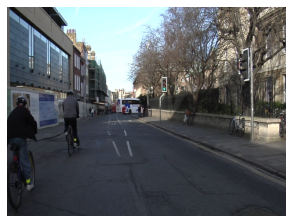

In [9]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [10]:
get_msk = lambda o : path/'labels'/f'{o.stem}_P{o.suffix}'

In [11]:
get_msk(img_fn)

Path('/storage/data/camvid/labels/0016E5_08131_P.png')

<AxesSubplot:>

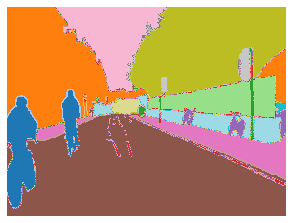

In [12]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [13]:
tensor(msk)

tensor([[ 4,  4,  4,  ..., 26, 26, 26],
        [ 4,  4,  4,  ..., 26, 26, 26],
        [ 4,  4,  4,  ..., 26, 26, 26],
        ...,
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17]], dtype=torch.uint8)

In [14]:
codes = np.loadtxt(path/'codes.txt',dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [15]:
def FileSplitter(fname):
    "Split 'items' depending on the value of the mask"
    valid = Path(fname).read_text().split('\n')
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [16]:
sz = msk.shape; sz

(720, 960)

In [17]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [18]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items = get_image_files,
                  splitter = FileSplitter(path/'valid.txt'),
                  get_y = get_msk,
                  batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [19]:
dls = camvid.dataloaders(path/'images', bs=8)

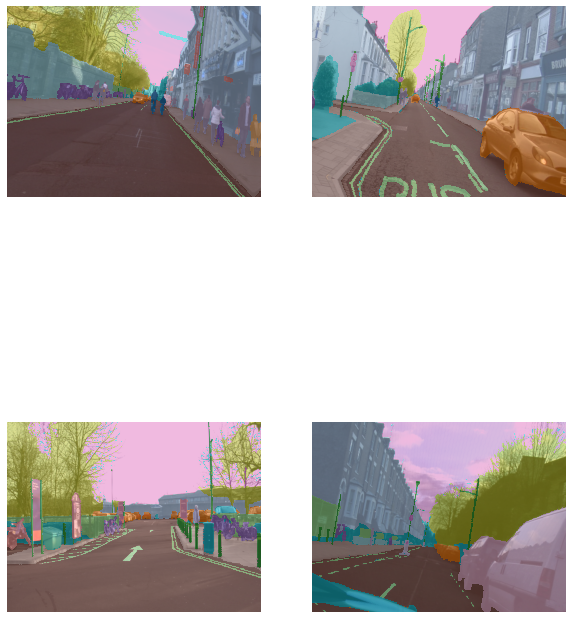

In [20]:
dls.show_batch(max_n=4, vmin=1, figsize=(10,14))

In [21]:
dls.vocab = codes

In [22]:
name2id = {v:k for k,v in enumerate(codes)}

In [23]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [24]:
void_code = name2id['Void']

In [25]:
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [26]:
tensor(msk).shape

torch.Size([720, 960])

## Model

In [27]:
config = unet_config(self_attention=True, act_cls=Mish)

NameError: name 'unet_config' is not defined

In [28]:
opt = ranger

In [34]:
learn = unet_learner(dls, resnet34,
                    opt_func=opt)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0010000000474974513)

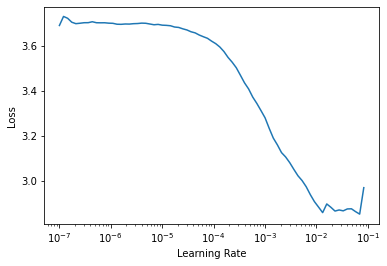

In [35]:
learn.lr_find()

In [36]:
lr = 2e-3

In [37]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,time
0,1.456300,1.095805,01:10
1,0.892376,0.576524,01:09
2,0.680349,0.500684,01:08
3,0.601320,0.445987,01:09
4,0.533103,0.443713,01:08
5,0.499616,0.388342,01:09
6,0.439776,0.412135,01:09
7,0.432064,0.327269,01:09
8,0.380451,0.318544,01:09
9,0.336465,0.301749,01:09


In [38]:
learn.save('stage-1')
learn.load('stage-1')

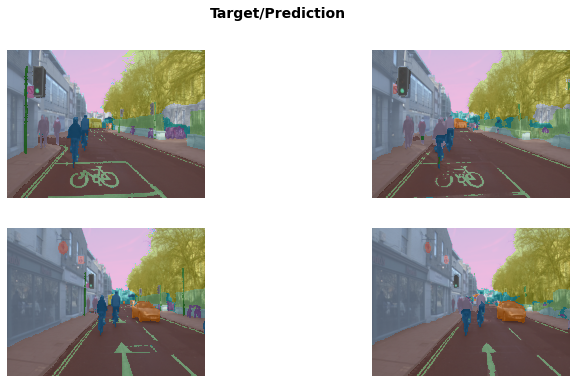

In [39]:
learn.show_results(max_n=4, figsize=(12,6))

## Inference

In [40]:
dl = learn.dls.test_dl(fnames[:5])

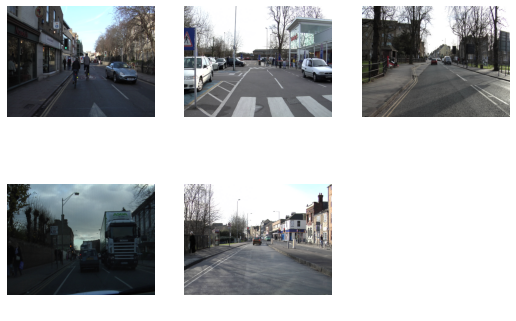

In [41]:
dl.show_batch()

In [42]:
preds = learn.get_preds(dl=dl)

In [43]:
preds[0].shape

(5, 32, 360, 480)

In [44]:
len(codes)

32

In [49]:
pred_1 = preds[0][0]

In [50]:
pred_1.shape

(32, 360, 480)

In [51]:
pred_arx = pred_1.argmax(dim=0)

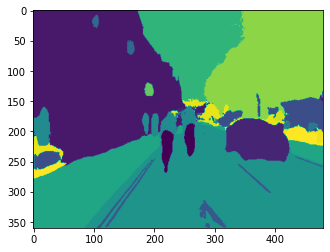

In [52]:
plt.imshow(pred_arx)

lets make a function to do this for all our files

In [53]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

In [54]:
torch.save(preds[0][0], 'image_1.pt')

In [55]:
pred_1 = torch.load('image_1.pt')

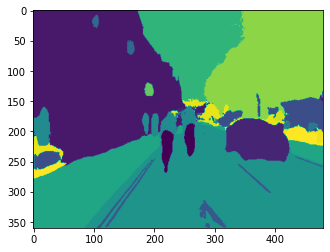

In [56]:
plt.imshow(pred_1.argmax(dim=0))